## Module and data

In [1]:
# Load the module for class initialization functions

using ExpectationMaximization
import ExpectationMaximization: initialize_class_assignments, m_step

# Make sure that this notebook is run from the main directory

endswith(pwd(), "/notebooks") && cd("..")
PROJECT_PATH = pwd()

include("$PROJECT_PATH/src/load_datasets.jl")

dataset = load_rte();

# [question x annotators x classes]
counts = dataset.crowd_counts

;

In [2]:
using LinearAlgebra: normalize

"""
Initialize parameters.
Reuses `m_step` and `initialize_class_assignments` defined for the manual implemention of the algorithm.
"""
function init_param(counts)
    class_marginals, error_rates = m_step(FDS(), counts, initialize_class_assignments(FDS(), counts))
    return normalize(class_marginals[:], 1)
end

third(x) = x[3]

"""
Element-wise multiplication in order to remove annotators that didn't answer the question.
"""
function onehot_choices_to_categorical(x::Array{<:Real, 3})::Matrix{Int}
    third.(argmax(x; dims=3)[:, :, 1]) .* maximum(x; dims=3)[:, :, 1]
end

Q, A, O = size(counts) # questions, answers, options
choices = onehot_choices_to_categorical(counts)
class_marginals = init_param(counts)

;

In [3]:
using Distributions
using LogExpFunctions
using IterTools
using Turing


isnanbool(x) = isnan(x) === true
hasnans(x::AbstractArray) = any(isnanbool.(x))

@model function em_fds(
    choices::Matrix{Int}, # [Q x A]
    unnormalized_class_marginals::Vector{<:Real} # [O] (probability vector)
)
    # Get dimensions
    Q, A = size(choices) # questions, answers
    O = length(unnormalized_class_marginals) # options

    # eq (4)
    normalized_class_marginals = softmax(unnormalized_class_marginals)
    p_Y = Categorical(normalized_class_marginals)
    
    # sample answer sheet
    Ys ~ filldist(p_Y, Q)

    # eq (3)

    # [A x O]
    S = map(product(1:A, 1:O)) do (a, o)
        length([q for q in 1:Q 
                  if Ys[q] == o
                  && choices[q, a] ≠ 0])
    end

    # [A x O x O]
    T = map(product(1:A, 1:O, 1:O)) do (a, o_true, o_answered)
        length([q for q in 1:Q
                if Ys[q] == o_true 
                && choices[q, a] == o_answered])
    end

    #=
    When `NaN`s occur in `error_rates`, they are arranged along the third dimension,
    which is sampled as a probability vector.
    The minimum risk way of dealing with this is to replace such cases with
    priors/`normalized_class_marginals`.
    =#
    error_rates = T ./ S
    for a in 1:A, o in 1:O
        if hasnans(error_rates[a, o, :])
            error_rates[a, o, :] = normalized_class_marginals
        end
    end
    
    if hasnans(error_rates)
        @show Ys
        @show S
        @show T
        @show error_rates
    end

    #TODO: try moving it into the loop, maybe avoids lines or add an if inside line 62 
    p_c_given_Y = [hasnans(error_rates[a, o, :]) ? nothing : Categorical(error_rates[a, o, :]) for a in 1:A, o in 1:O]
    for q in 1:Q, a in 1:A
        choices[q, a] == 0 && continue
        choices[q, a] ~ p_c_given_Y[a, Ys[q]]
    end
end


em_fds (generic function with 2 methods)

In [4]:
function get_latent(chn; keep_pct=.5, use_every=1)
    # [latent_dim, num_samples]
    chn.value.data[floor(Int, keep_pct * end) : use_every : end, 1:800] |> Matrix{Int} |> transpose
end

function make_obj(latent)
    function obj(unnormalized_class_marginals)
        normalized_class_marginals = normalize(unnormalized_class_marginals, 1)
        return -mean([
            logjoint(em_fds(choices, normalized_class_marginals), (; Ys=Ys))
            for Ys in eachcol(latent)
            ])
    end
end

make_obj (generic function with 1 method)

In [ ]:
using JLD
trace = load("./trace.jld")["trace"]
;

In [15]:
using Random
using ProgressMeter
using Optim

Random.seed!(42)

num_particles = 20
num_samples = 20
num_iterations = 10
sampler = PG(num_particles)

# class_marginals = init_param(counts)
# trace = (chn=[], opt=[])

@showprogress for i in 1:num_iterations
    # E-step
    chn = sample(em_fds(choices, class_marginals), sampler, num_samples; progress=false)
    push!(trace.chn, chn)
    
    # M-step
    opt = optimize(make_obj(get_latent(chn)), class_marginals)
    push!(trace.opt, opt)
    class_marginals = opt.minimizer

    # Report
    @show i
    @show opt.minimum
    @show chn.logevidence
    flush(stdout)
    display(param)
end

using Dates
using JLD
savename = "./trace_$(split(string(now()), '.')[1]).jld"
save(savename, "trace", trace)
println("Saved as $savename")

1: 5391.278441166886 | -4841.762855346546
2: 5401.081607980987 | -4850.669073149292


Progress:  30%|████████████▎                            |  ETA: 0:40:42

3: 5392.391406635477 | -4844.609123456079


Progress:  40%|████████████████▍                        |  ETA: 0:34:19

4: 5390.231063276086 | -4838.213193128126


Progress:  50%|████████████████████▌                    |  ETA: 0:27:50

5: 5394.213104060603 | -4847.504800422126


Progress:  60%|████████████████████████▋                |  ETA: 0:22:10

6: 5386.164890838642 | -4830.3463431728005


Progress:  70%|████████████████████████████▊            |  ETA: 0:16:19

7: 5372.201448221067 | -4833.086603139959


Progress:  80%|████████████████████████████████▊        |  ETA: 0:10:48

8: 5373.958371991393 | -4847.871697925949


Progress:  90%|████████████████████████████████████▉    |  ETA: 0:05:20

9: 5182.5886704143695 | -4834.860501036534


Progress: 100%|█████████████████████████████████████████| Time: 0:52:22


10: 5188.563500000966 | -4936.822223602552
Saved as ./trace_2022-09-19T19:37:32.jld


In [7]:
# class_marginals = trace.opt[end].minimizer
# chn = sample(em_fds(choices, class_marginals), sampler, num_samples)

Sampling: 100%|█████████████████████████████████████████| Time: 0:04:11


Chains MCMC chain (20×802×1 Array{Float64, 3}):

Log evidence      = -4833.658211674445
Iterations        = 1:1:20
Number of chains  = 1
Samples per chain = 20
Wall duration     = 273.03 seconds
Compute duration  = 273.03 seconds
parameters        = Ys[1], Ys[2], Ys[3], Ys[4], Ys[5], Ys[6], Ys[7], Ys[8], Ys[9], Ys[10], Ys[11], Ys[12], Ys[13], Ys[14], Ys[15], Ys[16], Ys[17], Ys[18], Ys[19], Ys[20], Ys[21], Ys[22], Ys[23], Ys[24], Ys[25], Ys[26], Ys[27], Ys[28], Ys[29], Ys[30], Ys[31], Ys[32], Ys[33], Ys[34], Ys[35], Ys[36], Ys[37], Ys[38], Ys[39], Ys[40], Ys[41], Ys[42], Ys[43], Ys[44], Ys[45], Ys[46], Ys[47], Ys[48], Ys[49], Ys[50], Ys[51], Ys[52], Ys[53], Ys[54], Ys[55], Ys[56], Ys[57], Ys[58], Ys[59], Ys[60], Ys[61], Ys[62], Ys[63], Ys[64], Ys[65], Ys[66], Ys[67], Ys[68], Ys[69], Ys[70], Ys[71], Ys[72], Ys[73], Ys[74], Ys[75], Ys[76], Ys[77], Ys[78], Ys[79], Ys[80], Ys[81], Ys[82], Ys[83], Ys[84], Ys[85], Ys[86], Ys[87], Ys[88], Ys[89], Ys[90], Ys[91], Ys[92], Ys[93], Ys[94], Ys[95],

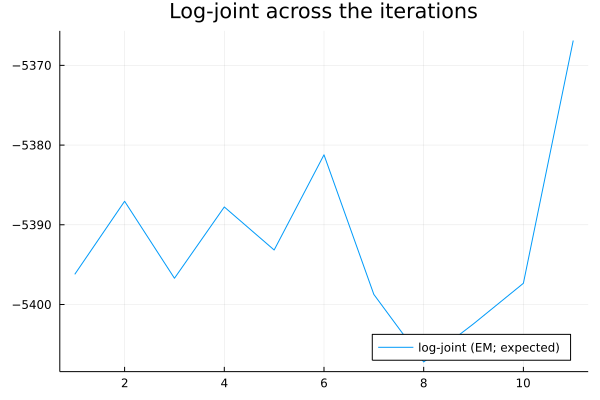

In [20]:
using StatsPlots

plot(map(opt -> -opt.minimum, trace.opt);
     label="log-joint (EM; expected)",
     legend=:bottomright,
     title="Log-joint across the iterations")

In [18]:
Ys = [2, 1, 1, 1, 2, 2, 1, 1, 1, 1, 2, 1, 1, 2, 2, 1, 2, 1, 1, 1, 1, 1, 2, 2, 1, 1, 2, 2, 1, 2, 1, 1, 2, 1, 2, 1, 1, 1, 1, 2, 2, 1, 1, 1, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 1, 1, 2, 1, 2, 1, 1, 2, 1, 2, 2, 1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2, 1, 1, 2, 2, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 2, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 2, 1, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 2, 2, 1, 1, 1, 2, 1, 2, 2, 1, 1, 2, 1, 1, 2, 1, 2, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 2, 1, 2, 2, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 2, 2, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 2, 1, 1, 2, 1, 2, 1, 1, 1, 2, 1, 1, 2, 1, 2, 1, 1, 2, 2, 1, 1, 1, 2, 1, 2, 1, 1, 1, 2, 1, 2, 1, 2, 2, 1, 1, 2, 1, 2, 2, 2, 2, 2, 1, 1, 2, 1, 1, 2, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 2, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 2, 2, 1, 1, 2, 2, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 2, 2, 2, 1, 1, 1, 1, 2, 1, 2, 2, 1, 2, 1, 1, 2, 1, 2, 1, 1, 2, 1, 1, 1, 2, 1, 1, 2, 2, 1, 1, 2, 2, 1, 1, 1, 2, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 2, 2, 1, 2, 1, 2, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 1, 1, 1, 2, 1, 1, 2, 1, 2, 1, 1, 1, 2, 2, 1, 2, 1, 1, 1, 1, 2, 1, 2, 2, 1, 1, 2, 1, 2, 1, 2, 1, 1, 2, 2, 1, 1, 2, 1, 1, 1, 2, 2, 1, 2, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 2, 2, 2, 2, 2, 1, 2, 2, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 2, 1, 1, 1, 2, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 2, 1, 1, 2, 1, 2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 2, 2, 1, 2, 2, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 2, 1, 2, 1, 1, 1, 1, 2, 1, 2, 2, 2, 1, 1, 1, 1, 1, 2, 2, 1, 2, 1, 1, 1, 2, 1, 1, 2, 2, 1, 1, 2, 2, 1, 1, 1, 1, 2, 2, 1, 1, 2, 1, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1]
S = [23 17; 267 153; 13 7; 182 98; 13 7; 469 231; 68 32; 348 192; 532 268; 508 252; 52 28; 53 27; 12 8; 26 14; 84 56; 121 59; 12 8; 28 12; 16 4; 16 4; 40 20; 49 11; 11 9; 35 25; 11 9; 11 9; 11 9; 11 9; 12 8; 12 8; 25 15; 13 7; 37 23; 13 7; 17 3; 17 3; 30 10; 17 3; 17 3; 13 7; 30 10; 39 21; 13 7; 12 8; 42 18; 12 8; 60 20; 12 8; 12 8; 12 8; 26 14; 14 6; 14 6; 25 15; 11 9; 60 20; 11 9; 11 9; 11 9; 11 9; 11 9; 11 9; 11 9; 11 9; 11 9; 14 6; 14 6; 38 22; 14 6; 14 6; 14 6; 13 7; 13 7; 13 7; 13 7; 14 6; 14 6; 14 6; 14 6; 14 6; 9 11; 9 11; 20 20; 9 11; 15 5; 28 12; 15 5; 15 5; 12 8; 12 8; 12 8; 13 7; 13 7; 13 7; 12 8; 12 8; 12 8; 12 8; 11 9; 35 25; 37 23; 13 7; 13 7; 13 7; 13 7; 13 7; 28 12; 14 6; 14 6; 14 6; 14 6; 14 6; 12 8; 12 8; 12 8; 12 8; 12 8; 12 8; 23 17; 12 8; 17 3; 34 6; 17 3; 46 14; 29 11; 12 8; 12 8; 27 13; 17 3; 17 3; 17 3; 17 3; 10 10; 10 10; 20 0; 20 0; 20 0; 20 0; 14 6; 14 6; 14 6; 17 3; 17 3; 17 3; 27 13; 15 5; 15 5; 15 5; 15 5; 12 8; 12 8; 12 8; 15 5; 15 5; 15 5; 15 5; 15 5; 11 9; 11 9; 15 5; 15 5; 27 13; 12 8; 12 8]
T = [15 11; 125 78; 6 4; 84 47; 6 4; 289 145; 39 16; 258 150; 430 223; 389 195; 24 15; 13 9; 2 2; 11 6; 35 27; 69 44; 7 3; 23 11; 14 4; 7 3; 17 14; 23 7; 4 3; 16 9; 5 3; 5 3; 6 4; 6 3; 7 2; 6 2; 11 7; 7 5; 16 14; 5 4; 7 1; 5 1; 10 3; 7 0; 12 1; 6 5; 9 6; 10 9; 8 5; 9 6; 23 10; 7 5; 24 5; 5 5; 10 8; 5 2; 10 6; 9 5; 9 4; 12 9; 5 6; 35 14; 4 5; 5 5; 5 6; 5 6; 3 5; 3 3; 2 3; 4 5; 1 1; 7 4; 6 4; 18 9; 10 3; 5 3; 7 4; 10 3; 9 3; 5 4; 7 3; 6 2; 8 5; 6 5; 10 4; 9 6; 6 7; 1 4; 12 11; 5 8; 5 1; 14 7; 9 2; 15 5; 8 5; 7 4; 8 6; 5 3; 6 4; 5 4; 5 3; 4 4; 5 3; 4 4; 7 6; 14 12; 14 9; 3 4; 0 2; 2 3; 2 3; 4 3; 6 3; 5 2; 3 3; 2 0; 2 0; 3 2; 4 4; 6 5; 6 5; 6 5; 6 4; 4 5; 8 8; 4 5; 12 2; 21 4; 9 1; 28 8; 16 4; 4 5; 3 5; 16 7; 6 1; 5 1; 3 1; 3 1; 7 5; 6 2; 9 0; 11 0; 8 0; 9 0; 6 5; 6 2; 7 3; 9 0; 7 1; 9 1; 14 5; 8 3; 11 3; 8 4; 10 1; 5 2; 2 1; 7 4; 11 2; 9 2; 8 2; 13 4; 9 2; 5 2; 5 3; 7 1; 8 0; 15 6; 7 4; 6 4;;; 8 6; 142 75; 7 3; 98 51; 7 3; 180 86; 29 16; 90 42; 102 45; 119 57; 28 13; 40 18; 10 6; 15 8; 49 29; 52 15; 5 5; 5 1; 2 0; 9 1; 23 6; 26 4; 7 6; 19 16; 6 6; 6 6; 5 5; 5 6; 5 6; 6 6; 14 8; 6 2; 21 9; 8 3; 10 2; 12 2; 20 7; 10 3; 5 2; 7 2; 21 4; 29 12; 5 2; 3 2; 19 8; 5 3; 36 15; 7 3; 2 0; 7 6; 16 8; 5 1; 5 2; 13 6; 6 3; 25 6; 7 4; 6 4; 6 3; 6 3; 8 4; 8 6; 9 6; 7 4; 10 8; 7 2; 8 2; 20 13; 4 3; 9 3; 7 2; 3 4; 4 4; 8 3; 6 4; 8 4; 6 1; 8 1; 4 2; 5 0; 3 4; 8 7; 8 9; 4 3; 10 4; 14 5; 6 3; 0 0; 4 3; 5 4; 4 2; 8 4; 7 3; 8 3; 7 5; 8 4; 7 5; 8 4; 4 3; 21 13; 23 14; 10 3; 13 5; 11 4; 11 4; 9 4; 22 9; 9 4; 11 3; 12 6; 12 6; 11 4; 8 4; 6 3; 6 3; 6 3; 6 4; 8 3; 15 9; 8 3; 5 1; 13 2; 8 2; 18 6; 13 7; 8 3; 9 3; 11 6; 11 2; 12 2; 14 2; 14 2; 3 5; 4 8; 11 0; 9 0; 12 0; 11 0; 8 1; 8 4; 7 3; 8 3; 10 2; 8 2; 13 8; 7 2; 4 2; 7 1; 5 4; 7 6; 10 7; 5 4; 4 3; 6 3; 7 3; 2 1; 6 3; 6 7; 6 6; 8 4; 7 5; 12 7; 5 4; 6 4]
error_rates = [0.6521739130434783 0.6470588235294118; 0.4681647940074906 0.5098039215686274; 0.46153846153846156 0.5714285714285714; 0.46153846153846156 0.47959183673469385; 0.46153846153846156 0.5714285714285714; 0.6162046908315565 0.6277056277056277; 0.5735294117647058 0.5; 0.7413793103448276 0.78125; 0.8082706766917294 0.832089552238806; 0.765748031496063 0.7738095238095238; 0.46153846153846156 0.5357142857142857; 0.24528301886792453 0.3333333333333333; 0.16666666666666666 0.25; 0.4230769230769231 0.42857142857142855; 0.4166666666666667 0.48214285714285715; 0.5702479338842975 0.7457627118644068; 0.5833333333333334 0.375; 0.8214285714285714 0.9166666666666666; 0.875 1.0; 0.4375 0.75; 0.425 0.7; 0.46938775510204084 0.6363636363636364; 0.36363636363636365 0.3333333333333333; 0.45714285714285713 0.36; 0.45454545454545453 0.3333333333333333; 0.45454545454545453 0.3333333333333333; 0.5454545454545454 0.4444444444444444; 0.5454545454545454 0.3333333333333333; 0.5833333333333334 0.25; 0.5 0.25; 0.44 0.4666666666666667; 0.5384615384615384 0.7142857142857143; 0.43243243243243246 0.6086956521739131; 0.38461538461538464 0.5714285714285714; 0.4117647058823529 0.3333333333333333; 0.29411764705882354 0.3333333333333333; 0.3333333333333333 0.3; 0.4117647058823529 0.0; 0.7058823529411765 0.3333333333333333; 0.46153846153846156 0.7142857142857143; 0.3 0.6; 0.2564102564102564 0.42857142857142855; 0.6153846153846154 0.7142857142857143; 0.75 0.75; 0.5476190476190477 0.5555555555555556; 0.5833333333333334 0.625; 0.4 0.25; 0.4166666666666667 0.625; 0.8333333333333334 1.0; 0.4166666666666667 0.25; 0.38461538461538464 0.42857142857142855; 0.6428571428571429 0.8333333333333334; 0.6428571428571429 0.6666666666666666; 0.48 0.6; 0.45454545454545453 0.6666666666666666; 0.5833333333333334 0.7; 0.36363636363636365 0.5555555555555556; 0.45454545454545453 0.5555555555555556; 0.45454545454545453 0.6666666666666666; 0.45454545454545453 0.6666666666666666; 0.2727272727272727 0.5555555555555556; 0.2727272727272727 0.3333333333333333; 0.18181818181818182 0.3333333333333333; 0.36363636363636365 0.5555555555555556; 0.09090909090909091 0.1111111111111111; 0.5 0.6666666666666666; 0.42857142857142855 0.6666666666666666; 0.47368421052631576 0.4090909090909091; 0.7142857142857143 0.5; 0.35714285714285715 0.5; 0.5 0.6666666666666666; 0.7692307692307693 0.42857142857142855; 0.6923076923076923 0.42857142857142855; 0.38461538461538464 0.5714285714285714; 0.5384615384615384 0.42857142857142855; 0.42857142857142855 0.3333333333333333; 0.5714285714285714 0.8333333333333334; 0.42857142857142855 0.8333333333333334; 0.7142857142857143 0.6666666666666666; 0.6428571428571429 1.0; 0.6666666666666666 0.6363636363636364; 0.1111111111111111 0.36363636363636365; 0.6 0.55; 0.5555555555555556 0.7272727272727273; 0.3333333333333333 0.2; 0.5 0.5833333333333334; 0.6 0.4; 1.0 1.0; 0.6666666666666666 0.625; 0.5833333333333334 0.5; 0.6666666666666666 0.75; 0.38461538461538464 0.42857142857142855; 0.46153846153846156 0.5714285714285714; 0.38461538461538464 0.5714285714285714; 0.4166666666666667 0.375; 0.3333333333333333 0.5; 0.4166666666666667 0.375; 0.3333333333333333 0.5; 0.6363636363636364 0.6666666666666666; 0.4 0.48; 0.3783783783783784 0.391304347826087; 0.23076923076923078 0.5714285714285714; 0.0 0.2857142857142857; 0.15384615384615385 0.42857142857142855; 0.15384615384615385 0.42857142857142855; 0.3076923076923077 0.42857142857142855; 0.21428571428571427 0.25; 0.35714285714285715 0.3333333333333333; 0.21428571428571427 0.5; 0.14285714285714285 0.0; 0.14285714285714285 0.0; 0.21428571428571427 0.3333333333333333; 0.3333333333333333 0.5; 0.5 0.625; 0.5 0.625; 0.5 0.625; 0.5 0.5; 0.3333333333333333 0.625; 0.34782608695652173 0.47058823529411764; 0.3333333333333333 0.625; 0.7058823529411765 0.6666666666666666; 0.6176470588235294 0.6666666666666666; 0.5294117647058824 0.3333333333333333; 0.6086956521739131 0.5714285714285714; 0.5517241379310345 0.36363636363636365; 0.3333333333333333 0.625; 0.25 0.625; 0.5925925925925926 0.5384615384615384; 0.35294117647058826 0.3333333333333333; 0.29411764705882354 0.3333333333333333; 0.17647058823529413 0.3333333333333333; 0.17647058823529413 0.3333333333333333; 0.7 0.5; 0.6 0.2; 0.45 NaN; 0.55 NaN; 0.4 NaN; 0.45 NaN; 0.42857142857142855 0.8333333333333334; 0.42857142857142855 0.3333333333333333; 0.5 0.5; 0.5294117647058824 0.0; 0.4117647058823529 0.3333333333333333; 0.5294117647058824 0.3333333333333333; 0.5185185185185185 0.38461538461538464; 0.5333333333333333 0.6; 0.7333333333333333 0.6; 0.5333333333333333 0.8; 0.6666666666666666 0.2; 0.4166666666666667 0.25; 0.16666666666666666 0.125; 0.5833333333333334 0.5; 0.7333333333333333 0.4; 0.6 0.4; 0.5333333333333333 0.4; 0.8666666666666667 0.8; 0.6 0.4; 0.45454545454545453 0.2222222222222222; 0.45454545454545453 0.3333333333333333; 0.4666666666666667 0.2; 0.5333333333333333 0.0; 0.5555555555555556 0.46153846153846156; 0.5833333333333334 0.5; 0.5 0.5;;; 0.34782608695652173 0.35294117647058826; 0.5318352059925093 0.49019607843137253; 0.5384615384615384 0.42857142857142855; 0.5384615384615384 0.5204081632653061; 0.5384615384615384 0.42857142857142855; 0.3837953091684435 0.3722943722943723; 0.4264705882352941 0.5; 0.25862068965517243 0.21875; 0.19172932330827067 0.16791044776119404; 0.234251968503937 0.2261904761904762; 0.5384615384615384 0.4642857142857143; 0.7547169811320755 0.6666666666666666; 0.8333333333333334 0.75; 0.5769230769230769 0.5714285714285714; 0.5833333333333334 0.5178571428571429; 0.4297520661157025 0.2542372881355932; 0.4166666666666667 0.625; 0.17857142857142858 0.08333333333333333; 0.125 0.0; 0.5625 0.25; 0.575 0.3; 0.5306122448979592 0.36363636363636365; 0.6363636363636364 0.6666666666666666; 0.5428571428571428 0.64; 0.5454545454545454 0.6666666666666666; 0.5454545454545454 0.6666666666666666; 0.45454545454545453 0.5555555555555556; 0.45454545454545453 0.6666666666666666; 0.4166666666666667 0.75; 0.5 0.75; 0.56 0.5333333333333333; 0.46153846153846156 0.2857142857142857; 0.5675675675675675 0.391304347826087; 0.6153846153846154 0.42857142857142855; 0.5882352941176471 0.6666666666666666; 0.7058823529411765 0.6666666666666666; 0.6666666666666666 0.7; 0.5882352941176471 1.0; 0.29411764705882354 0.6666666666666666; 0.5384615384615384 0.2857142857142857; 0.7 0.4; 0.7435897435897436 0.5714285714285714; 0.38461538461538464 0.2857142857142857; 0.25 0.25; 0.4523809523809524 0.4444444444444444; 0.4166666666666667 0.375; 0.6 0.75; 0.5833333333333334 0.375; 0.16666666666666666 0.0; 0.5833333333333334 0.75; 0.6153846153846154 0.5714285714285714; 0.35714285714285715 0.16666666666666666; 0.35714285714285715 0.3333333333333333; 0.52 0.4; 0.5454545454545454 0.3333333333333333; 0.4166666666666667 0.3; 0.6363636363636364 0.4444444444444444; 0.5454545454545454 0.4444444444444444; 0.5454545454545454 0.3333333333333333; 0.5454545454545454 0.3333333333333333; 0.7272727272727273 0.4444444444444444; 0.7272727272727273 0.6666666666666666; 0.8181818181818182 0.6666666666666666; 0.6363636363636364 0.4444444444444444; 0.9090909090909091 0.8888888888888888; 0.5 0.3333333333333333; 0.5714285714285714 0.3333333333333333; 0.5263157894736842 0.5909090909090909; 0.2857142857142857 0.5; 0.6428571428571429 0.5; 0.5 0.3333333333333333; 0.23076923076923078 0.5714285714285714; 0.3076923076923077 0.5714285714285714; 0.6153846153846154 0.42857142857142855; 0.46153846153846156 0.5714285714285714; 0.5714285714285714 0.6666666666666666; 0.42857142857142855 0.16666666666666666; 0.5714285714285714 0.16666666666666666; 0.2857142857142857 0.3333333333333333; 0.35714285714285715 0.0; 0.3333333333333333 0.36363636363636365; 0.8888888888888888 0.6363636363636364; 0.4 0.45; 0.4444444444444444 0.2727272727272727; 0.6666666666666666 0.8; 0.5 0.4166666666666667; 0.4 0.6; 0.0 0.0; 0.3333333333333333 0.375; 0.4166666666666667 0.5; 0.3333333333333333 0.25; 0.6153846153846154 0.5714285714285714; 0.5384615384615384 0.42857142857142855; 0.6153846153846154 0.42857142857142855; 0.5833333333333334 0.625; 0.6666666666666666 0.5; 0.5833333333333334 0.625; 0.6666666666666666 0.5; 0.36363636363636365 0.3333333333333333; 0.6 0.52; 0.6216216216216216 0.6086956521739131; 0.7692307692307693 0.42857142857142855; 1.0 0.7142857142857143; 0.8461538461538461 0.5714285714285714; 0.8461538461538461 0.5714285714285714; 0.6923076923076923 0.5714285714285714; 0.7857142857142857 0.75; 0.6428571428571429 0.6666666666666666; 0.7857142857142857 0.5; 0.8571428571428571 1.0; 0.8571428571428571 1.0; 0.7857142857142857 0.6666666666666666; 0.6666666666666666 0.5; 0.5 0.375; 0.5 0.375; 0.5 0.375; 0.5 0.5; 0.6666666666666666 0.375; 0.6521739130434783 0.5294117647058824; 0.6666666666666666 0.375; 0.29411764705882354 0.3333333333333333; 0.38235294117647056 0.3333333333333333; 0.47058823529411764 0.6666666666666666; 0.391304347826087 0.42857142857142855; 0.4482758620689655 0.6363636363636364; 0.6666666666666666 0.375; 0.75 0.375; 0.4074074074074074 0.46153846153846156; 0.6470588235294118 0.6666666666666666; 0.7058823529411765 0.6666666666666666; 0.8235294117647058 0.6666666666666666; 0.8235294117647058 0.6666666666666666; 0.3 0.5; 0.4 0.8; 0.55 NaN; 0.45 NaN; 0.6 NaN; 0.55 NaN; 0.5714285714285714 0.16666666666666666; 0.5714285714285714 0.6666666666666666; 0.5 0.5; 0.47058823529411764 1.0; 0.5882352941176471 0.6666666666666666; 0.47058823529411764 0.6666666666666666; 0.48148148148148145 0.6153846153846154; 0.4666666666666667 0.4; 0.26666666666666666 0.4; 0.4666666666666667 0.2; 0.3333333333333333 0.8; 0.5833333333333334 0.75; 0.8333333333333334 0.875; 0.4166666666666667 0.5; 0.26666666666666666 0.6; 0.4 0.6; 0.4666666666666667 0.6; 0.13333333333333333 0.2; 0.4 0.6; 0.5454545454545454 0.7777777777777778; 0.5454545454545454 0.6666666666666666; 0.5333333333333333 0.8; 0.4666666666666667 1.0; 0.4444444444444444 0.5384615384615384; 0.4166666666666667 0.5; 0.5 0.5]
;

In [29]:
for i in 1:A, j in 1:O
    x = error_rates[i, j, :]
    if hasnans(x)
        println("$i:$j\n$x")
    end
end

135:2
[NaN, NaN]
136:2
[NaN, NaN]
137:2
[NaN, NaN]
138:2
[NaN, NaN]


In [55]:
er_[136,2,:]

2-element Vector{Float64}:
 0.5
 0.5